In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import t as t_dist

In [2]:
# make directory for predictions, if necessary
import os
ex = os.path.exists(os.path.join(os.getcwd(), "pred_netherlands"))

if not ex:
    os.mkdir(os.path.join(os.getcwd(), "pred_netherlands"))

In [52]:
# load data for netherlands
DE_heads = pd.read_csv("../../data/Netherlands/heads.csv", index_col=[0], parse_dates=True)

DE_features = pd.read_csv("../../data/Netherlands/input_data.csv", index_col=[0], parse_dates=True)

DE_features.columns = ["prec", "T_mean", "T_min", "T_max", "press", "hum", "wind", "rad", "et_pot"]

DE_full = pd.concat([DE_heads, DE_features], axis=1)
DE_full.head()

,head,prec,T_mean,T_min,T_max,press,hum,wind,rad,et_pot
1990-01-01,NaN,0.0,-1.71,-2.45,-1.64,1020.60004,93.06250,2.32,9.0,0.074566
1990-01-02,NaN,0.0,-0.66,-2.29,-0.24,1022.30000,92.05334,2.13,11.0,0.095090
1990-01-03,NaN,0.0,0.05,-0.62,0.69,1024.10000,91.48948,3.79,12.0,0.106630
1990-01-04,NaN,2.5,-0.29,-1.86,1.44,1021.60004,93.49286,3.91,10.0,0.087787
1990-01-05,NaN,0.0,3.21,1.35,3.84,1023.60004,93.28734,3.72,8.0,0.080110


In [53]:
# truncate
DE_full = DE_full.truncate(before="2000-01-01", after="2021-12-31").interpolate()
DE_features = DE_features.truncate(before="2000-01-01", after="2021-12-31").interpolate()
DE_heads = DE_heads.truncate(before="2000-01-01", after="2021-12-31").interpolate()

print(DE_features.isnull().any())
print(DE_heads.isnull().any())

prec      False
T_mean    False
T_min     False
T_max     False
press     False
hum       False
wind      False
rad       False
et_pot    False
dtype: bool
head    False
dtype: bool


0


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

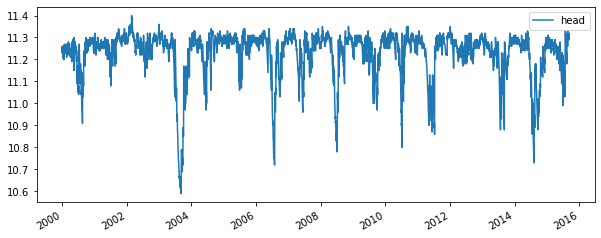

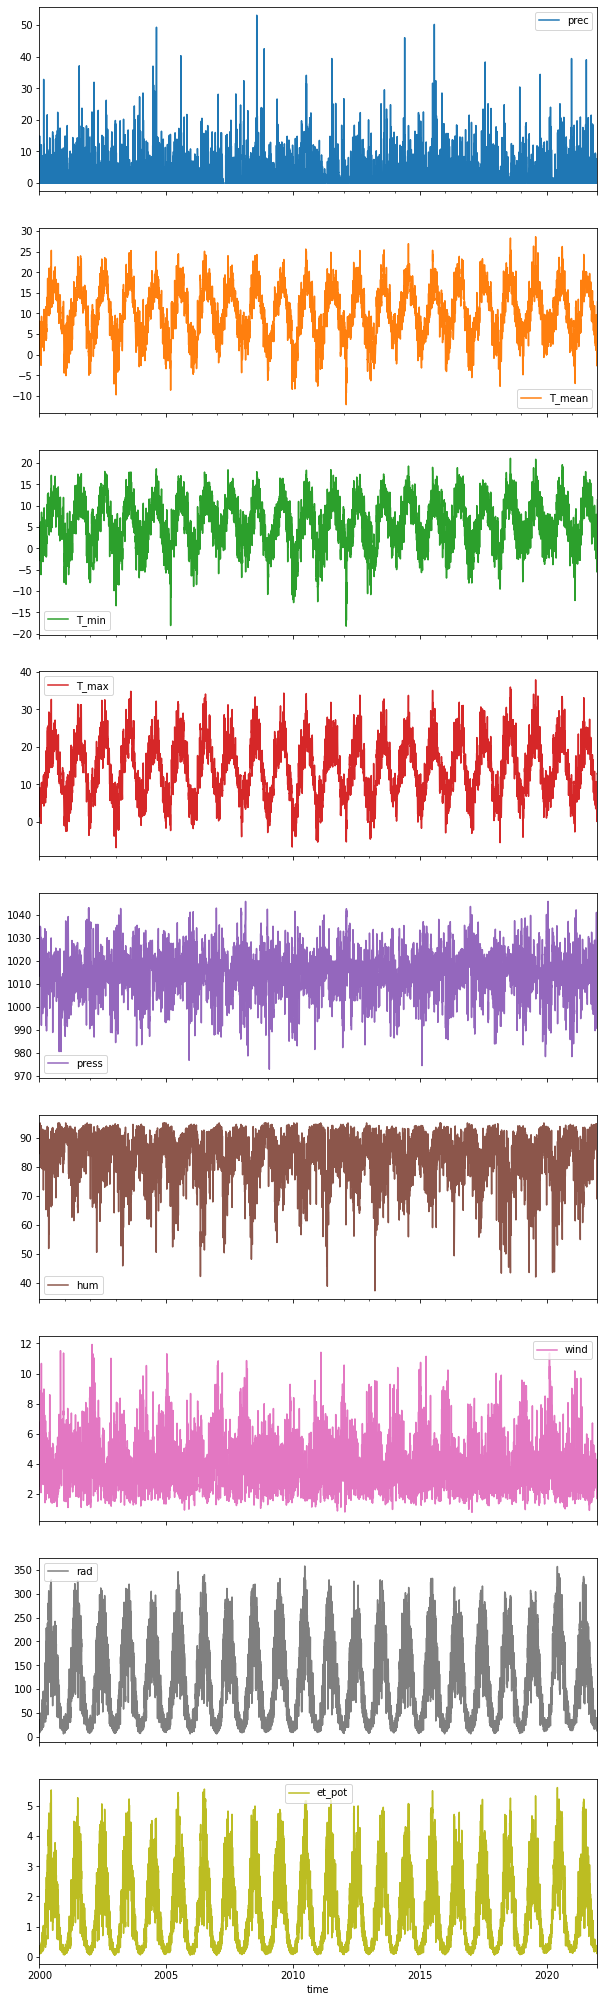

In [54]:
print(DE_full.isna().sum().sum())

# fig, ax = plt.subplots(nrows=2, figsize=(16, 10), sharex=True)

# ax[0].plot(DE_heads)

# ax[1].plot(DE_features)

DE_heads.plot(figsize=(10, 4))
DE_features.plot(subplots=True, figsize=(10, 36))

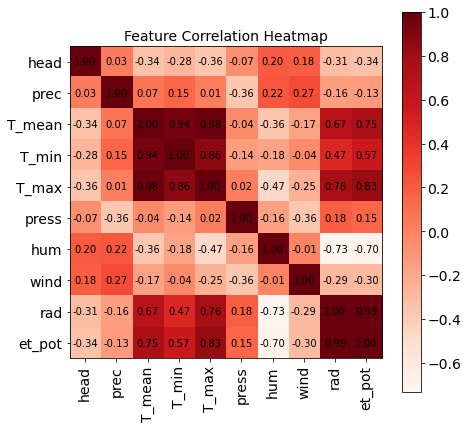

In [55]:
# show correlation
def show_heatmap(data):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    im = ax.imshow(data.corr(), cmap="Reds")
    # print(data.corr())
    ax.set_xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    ax.set_yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar(im)
    cb.ax.tick_params(labelsize=14)
    ax.set_title("Feature Correlation Heatmap", fontsize=14)
    
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            text = ax.text(i, j, "{:1.2f}".format(data.corr().values[i, j]), ha="center", va="center", c="black")

show_heatmap(DE_full)

In [56]:
def normalize(data, start, end, skl=True, scaler=MinMaxScaler((0, 1))):
    start_ = data.index.get_loc(start)
    end_ = data.index.get_loc(end)
    
    if skl == False:
        data_mean = data.values[start_:end_, :].mean(axis=0)
        data_std = data.values[start_:end_, :].std(axis=0)
        return pd.DataFrame((data.values - data_mean) / data_std, index=data.index)
    else:
        scaler.fit_transform(data.values[start_:end_, :])
        return pd.DataFrame(scaler.transform(data.values), index=data.index)

In [57]:
# select relevant features
# column_names = ["prec", "T_mean", "T_min", "T_max", "press", "hum", "wind", "rad", "et_pot"]
column_names = ["prec", "T_mean", "press", "hum", "et_pot"]
DE_features = DE_features[column_names]

# normalize

# (netherlands)
start = "2001-01-01"
end_train = "2012-12-31"
end_val = "2015-09-10"
start_test = "2016-01-01"
end_test = "2021-12-31"

scaler1 = MinMaxScaler((0, 1))
scaler2 = MinMaxScaler((0, 1))

DE_features = normalize(DE_features, start, end_train, skl=True, scaler=scaler1)
DE_heads = normalize(DE_heads, start, end_train, skl=True, scaler=scaler2)

print(DE_features.head())

                   0         1         2         3         4
time                                                        
2000-01-01  0.000000  0.430122  0.684932  0.989286  0.016474
2000-01-02  0.000000  0.484119  0.724659  0.978571  0.010236
2000-01-03  0.280603  0.537321  0.621918  0.967857  0.007304
2000-01-04  0.067797  0.448650  0.554795  0.991126  0.009494
2000-01-05  0.000000  0.426151  0.613699  0.922620  0.057726


In [9]:
# prepare data sets
train_data = DE_features.loc[start:end_train, :]
val_data = DE_features.loc[end_train:end_val, :]
test_data = DE_features.loc[start_test:end_test, :]

train_target = DE_heads.loc[start:end_train, :]
val_target = DE_heads.loc[end_train:end_val, :]
test_target = DE_heads.loc[start_test:end_test, :]

# concatenate dataframes
train_df = pd.concat([train_target, train_data], axis=1, ignore_index=False).interpolate()
val_df = pd.concat([val_target, val_data], axis=1, ignore_index=False).interpolate()
test_df = pd.concat([test_target, test_data], axis=1, ignore_index=False).interpolate()

# train_df.columns = ["heads"] + column_names[:n_components]
# val_df.columns = ["heads"] + column_names[:n_components]
# test_df.columns = ["heads"] + column_names[:n_components]

train_df.columns = ["heads"] + column_names
val_df.columns = ["heads"] + column_names
test_df.columns = ["heads"] + column_names

print(train_df.shape, train_df.isnull().any(), "\n")
print(val_df.shape, val_df.isnull().any(), "\n")
print(test_df.shape, test_df.isnull().any())

(4383, 6) heads     False
prec      False
T_mean    False
press     False
hum       False
et_pot    False
dtype: bool 

(984, 6) heads     False
prec      False
T_mean    False
press     False
hum       False
et_pot    False
dtype: bool 

(2192, 6) heads      True
prec      False
T_mean    False
press     False
hum       False
et_pot    False
dtype: bool


## Prepare Model Framework

In [10]:
# data windowing

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None, remove_label_col=False):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.remove_label_col = remove_label_col

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        if self.remove_label_col == False:
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        else:
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
            for i in self.label_columns_indices.keys():
                del self.column_indices[i]

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        if self.remove_label_col == True:
            inputs = features[:, self.input_slice, 1:]
            labels = features[:, self.labels_slice, 0:1]
        else:
            inputs = features[:, self.input_slice, :]
            labels = features[:, self.labels_slice, :]
        
        if self.label_columns is not None:
            if self.remove_label_col == True:
                labels = tf.stack([labels[:, :, self.label_columns_indices[name]] for name in self.label_columns], axis=-1)
            else:
                labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='T_mean', label_col="heads",max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
    
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(label_col, None)
            else:
                label_col_index = plot_col_index
    
            if label_col_index is None:
                continue
    
            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
    
            if n == 0:
                plt.legend()
    
        plt.xlabel('Time [d]')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=128,)
    
        ds = ds.map(self.split_window)
    
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            print("No Window_Generator._example found. Using training example.")
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [11]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [12]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    # model.compile(loss=tf.keras.losses.MeanSquaredError(),
    #               optimizer=tf.keras.optimizers.Adam(),
    #               metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

# Multi-Step Model

In [13]:
val_performance = {}
performance = {}

### LSTM Model

In [14]:
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1,
    label_columns=['heads'], remove_label_col=True)

wide_window

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Label column name(s): ['heads']

In [15]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [16]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

No Window_Generator._example found. Using training example.
Input shape: (128, 50, 5)
Output shape: (128, 50, 1)


### Perform a Single Fit

In [17]:
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
34/34 [==============================] - 9s 155ms/step - loss: 0.0611 - mean_absolute_error: 0.2515 - val_loss: 0.0222 - val_mean_absolute_error: 0.1393
Epoch 2/50
34/34 [==============================] - 4s 128ms/step - loss: 0.0199 - mean_absolute_error: 0.1248 - val_loss: 0.0180 - val_mean_absolute_error: 0.1269
Epoch 3/50
34/34 [==============================] - 4s 126ms/step - loss: 0.0165 - mean_absolute_error: 0.1120 - val_loss: 0.0156 - val_mean_absolute_error: 0.1181
Epoch 4/50
34/34 [==============================] - 4s 127ms/step - loss: 0.0143 - mean_absolute_error: 0.1033 - val_loss: 0.0131 - val_mean_absolute_error: 0.1098
Epoch 5/50
34/34 [==============================] - 4s 127ms/step - loss: 0.0125 - mean_absolute_error: 0.0969 - val_loss: 0.0121 - val_mean_absolute_error: 0.1033
Epoch 6/50
34/34 [==============================] - 4s 124ms/step - loss: 0.0111 - mean_absolute_error: 0.0919 - val_loss: 0.0102 - val_mean_absolute_error: 0.0964
Epoch 7/50
34/34

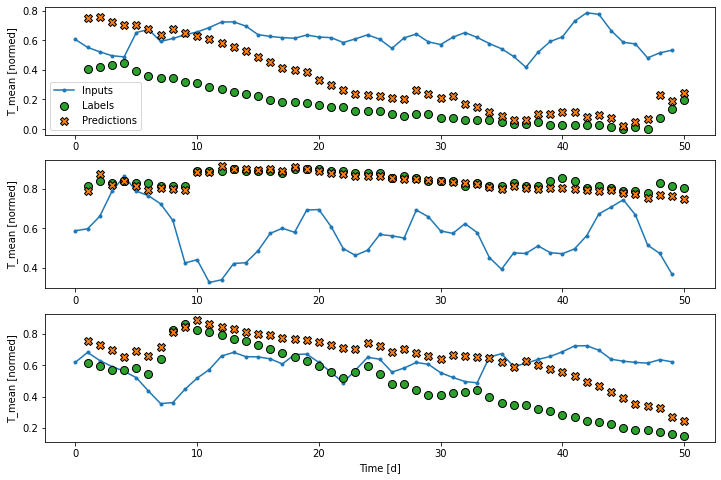

In [18]:
wide_window.plot(lstm_model)

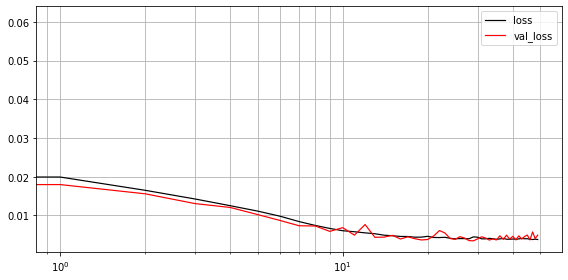

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax.plot(history.history["loss"], label="loss", lw=1.2, c="black")
ax.plot(history.history["val_loss"], label="val_loss", lw=1.2, c="red")
ax.legend()
ax.set_xscale("log")
# ax.set_yscale("log")
ax.grid(True, "both")

plt.tight_layout()

In [20]:
# predictions
test_data = test_df.values
test_data = test_data[np.newaxis, :, 1:]
#     
out = lstm_model.predict(test_data)

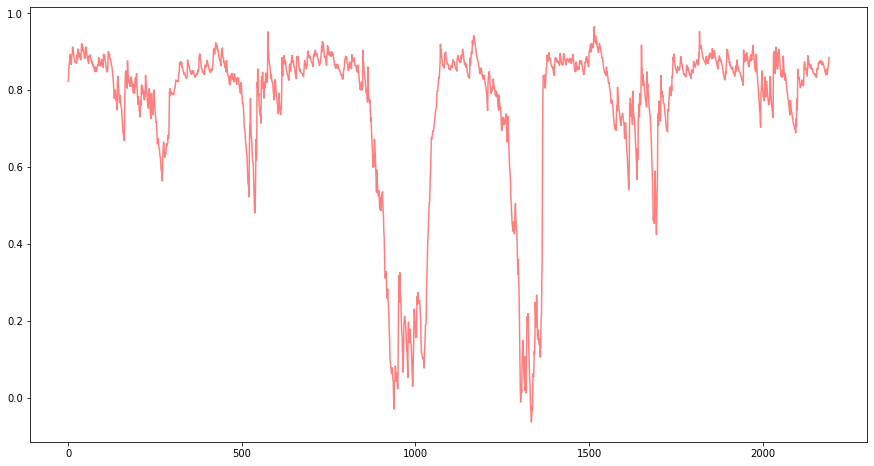

In [21]:
out = np.array(out)
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(test_df.iloc[:, 0].values)

ax.plot(out[0, :, 0], color="red", alpha=0.5)

(1, 7559, 5)
(1, 7559, 1)


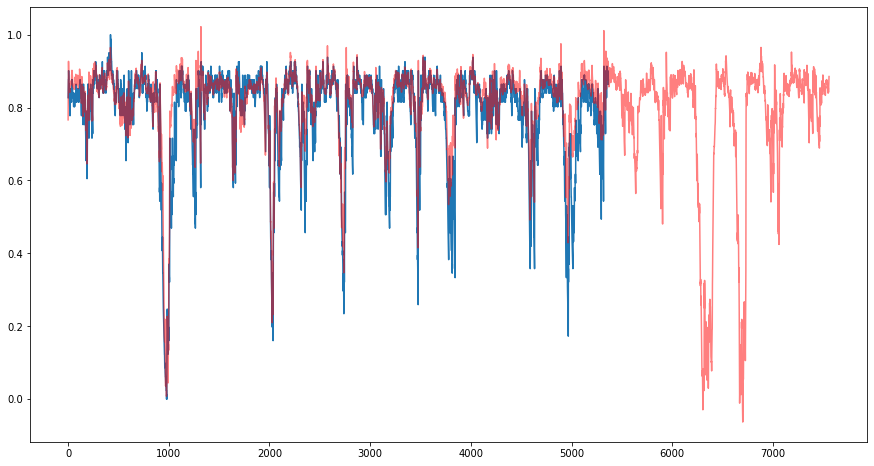

In [22]:
# concatenate individual dfs

df_analysis = pd.concat([train_df, val_df, test_df]).values
analysis_data = df_analysis[np.newaxis, :, 1:]

out = lstm_model.predict(analysis_data)

out = np.array(out)
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_analysis[:, 0])

print(np.shape(analysis_data))
print(np.shape(out))

ax.plot(out[0, :, 0], color="red", alpha=0.5)

In [23]:
res = df_analysis[:, 0] - out[0, :, 0]
res = res[~np.isnan(res)]

In [24]:
mse = np.sum(res ** 2)
R2 = np.corrcoef(df_analysis[:(len(train_df) + len(val_df)), 0], out[0, :(len(train_df) + len(val_df)), 0])[0, 1] ** 2
print("MSE: ", mse)
print("R2 :", R2)

MSE:  23.27765761516548
R2 : 0.8265663131357253


p = 0.000
p2 = 0.466


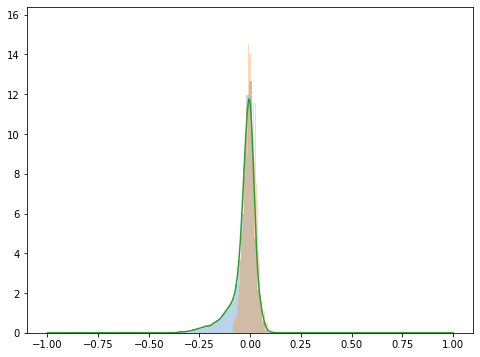

In [25]:
from scipy import stats

bins = np.arange(-100, 100, 10)

kde = stats.gaussian_kde(res)
xx = np.linspace(-1, 1, 1000)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(res, density=True, bins=50, alpha=0.3)
ax.hist(np.random.normal(0, 0.03, 1000), bins=50, density=True, alpha=0.3)
ax.plot(xx, kde(xx))

k, p = stats.normaltest(res)
k2, p2 = stats.normaltest(np.random.normal(0, 1, 100000))
print("p = {:1.3f}".format(p)) # if p < alpha, the sample does NOT come from a normal dist.
print("p2 = {:1.3f}".format(p2))

## Include Dropout and Perform Multiple Fits

In [26]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=100,
                                                  mode='min')
    
lstm_model.compile(loss=tf.keras.losses.Huber(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [27]:
df_analysis = pd.concat([train_df, val_df, test_df])
values_analysis = df_analysis.values
analysis_data = values_analysis[np.newaxis, :, 1:]

In [28]:
n_members = 100
results = []
for i in range(n_members):
    history = lstm_model.fit(wide_window.train, epochs=50,
                        validation_data=wide_window.val,
                        callbacks=[early_stopping], verbose=0)
    
    # fit
    # history = compile_and_fit(lstm_model, wide_window)
    val_performance['LSTM {}'.format(i)] = lstm_model.evaluate(wide_window.val)
    performance['LSTM {}'.format(i)] = lstm_model.evaluate(wide_window.test, verbose=0)
    
    # predict for whole period    
    out = lstm_model.predict(analysis_data)
    out = np.array(out)
    # we're predicting one time step more, i.e., 2021-06-01
    date_range = pd.date_range(start=df_analysis.index[0], periods=len(values_analysis), freq="D")
    out = pd.Series(data=out[0, :, 0], index=date_range)
    out.to_csv("pred_netherlands/pred_{}.csv".format(i), sep=";")
    results.append(out)

8/8 [==============================] - 1s 53ms/step - loss: 0.0103 - mean_absolute_error: 0.0952


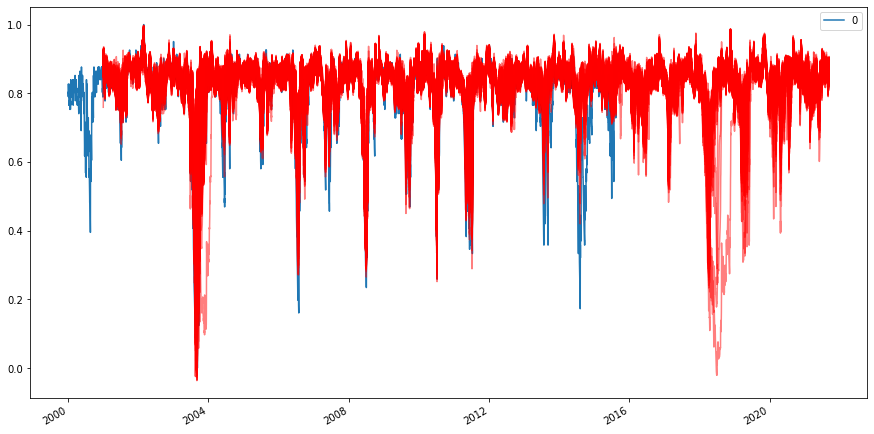

In [29]:
fig, ax = plt.subplots(figsize=(15, 8))
DE_heads.plot(ax=ax)

for i in results:
    i.plot(color="red", alpha=0.5, ax=ax)

## Calculate Mean Prediction and Confidence Intervals from the Ensemble

In [73]:
# load time series
members = []
members_values = []

n_members = 100
for i in range(n_members):
    s = pd.read_csv("pred_netherlands/pred_{}.csv".format(i), sep=";", index_col=[0],
                    parse_dates=True, infer_datetime_format=True)
    members.append(s)
    members_values.append(s.values)
    
members_values = np.array(members_values)

In [74]:
conf = 0.95
dof = n_members - 1
t_crit = np.abs(t_dist.ppf((1 - conf) / 2, dof))

mean = []
upper_ci = []
lower_ci = []

# iterate over time steps and calculate mean and confidence intervals
for i in range(len(members_values[0, :, 0])):
    mean_ = members_values[:, i, 0].mean()
    # mean_ = scaler2.inverse_transform(np.array([mean_]).reshape(1, -1))
    mean.append(mean_)
    
    lower_ci_ = mean_ - members_values[:, i, 0].std() * t_crit / np.sqrt(n_members)
    # lower_ci_ = scaler2.inverse_transform(np.array([lower_ci_]).reshape(1, -1))
    lower_ci.append(lower_ci_)
    
    upper_ci_ = mean_ + members_values[:, i, 0].std() * t_crit / np.sqrt(n_members)
    # upper_ci_ = scaler2.inverse_transform(np.array([upper_ci_]).reshape(1, -1))
    upper_ci.append(upper_ci_)
    
print(np.shape(mean))
print(np.shape(lower_ci))
print(np.shape(upper_ci))

(7559,)
(7559,)
(7559,)


In [75]:
# inverse scaling
mean = scaler2.inverse_transform(np.asarray(mean).reshape(-1, 1))
lower_ci = scaler2.inverse_transform(np.asarray(lower_ci).reshape(-1, 1))
upper_ci = scaler2.inverse_transform(np.asarray(upper_ci).reshape(-1, 1))

print(np.shape(mean))

(7559, 1)


In [76]:
# make series
mean_series = pd.Series(mean[:, 0], index=members[0].index, dtype=float)
lower_ci_series = pd.Series(lower_ci[:, 0], index=members[0].index, dtype=float)
upper_ci_series = pd.Series(upper_ci[:, 0], index=members[0].index, dtype=float)

print(mean_series.isnull().any(), mean_series.min(), mean_series.max(), "\n")
print(lower_ci_series.isnull().any(), lower_ci_series.min(), lower_ci_series.max(), "\n")
print(upper_ci_series.isnull().any(), upper_ci_series.min(), upper_ci_series.max())

False 10.882555445868 11.384342078487 

False 10.868636991318608 11.381902814904725 

False 10.894096937615979 11.386781342069275


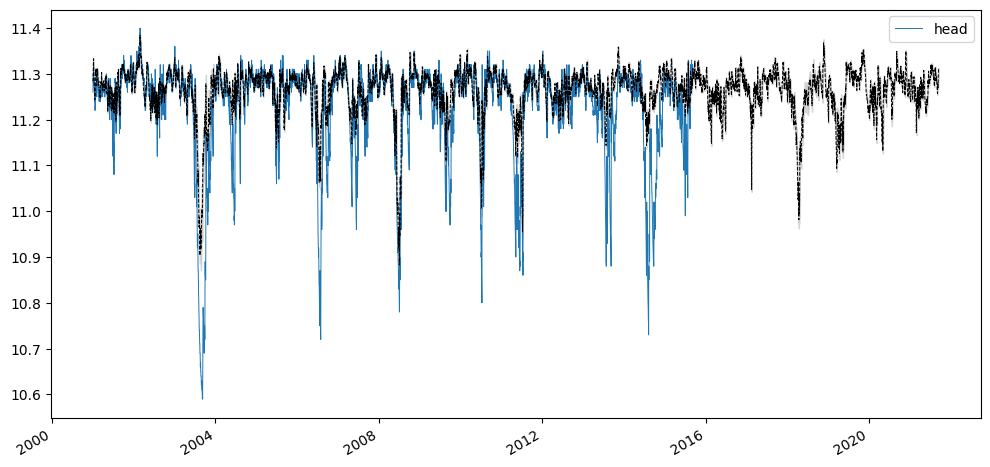

In [77]:
DE_heads = pd.read_csv("../../Data/Netherlands/heads.csv", index_col=[0], parse_dates=True)
DE_heads = DE_heads.truncate(before="2001-01-01", after="2021-12-31").interpolate()

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=100)
DE_heads.plot(ax=ax, lw=0.7)
ax.plot(mean_series, c="black", label="mean", lw=0.7, ls="--")
ax.fill_between(lower_ci_series.index, lower_ci_series.values, upper_ci_series.values, facecolor="gray", alpha=0.3, edgecolor="gray")

In [78]:
# export
series = pd.concat([mean_series, lower_ci_series, upper_ci_series], axis=1)
series.columns = ["Simulated Head", "95% Lower Bound", "95% Upper Bound"]
series = series.truncate(after="2021-12-31")
series.head()

,Simulated Head,95% Lower Bound,95% Upper Bound
2001-01-01,11.283119,11.281007,11.285231
2001-01-02,11.296031,11.294668,11.297393
2001-01-03,11.304933,11.303968,11.305898
2001-01-04,11.314043,11.311541,11.316546
2001-01-05,11.332879,11.331192,11.334565


In [79]:
series.to_csv("submission_form_Netherlands.csv", sep=",")